In [1]:
# RUTAS (ajustá a tu entorno)
RUN="/home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3"
GT="/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
META="/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv"
ANNO="/home/diego/Escritorio/limpio/roi_info_master.csv"   # Debe tener: AAL3_Name, Macro_Lobe, Refined_Network (y/o Yeo17_Network), ROI_TensorIdx

# ---------- 1) SHAP por fold ----------
for f in [1, 2, 3, 4, 5]:
  !python interpretar_fold_paper_mean.py shap \
    --run_dir "$RUN" \
    --fold $f \
    --clf mlp \
    --global_tensor_path "$GT" \
    --metadata_path "$META" \
    --channels_to_use 1 2 5 \
    --latent_dim 256 \
    --latent_features_type mu \
    --metadata_features Age Sex \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.2 \
    --intermediate_fc_dim_vae quarter \
    --vae_final_activation tanh \
    --kernel_nsamples 5000 \
    --shap_link logit \
    --bg_mode global_cn --bg_sample_size 100 --bg_seed 42 \
    --freeze_meta Age Sex --freeze_strategy train_stats \
    --shap_normalize by_logit_median

# ---------- 2) SALIENCY por fold ----------
for f in [1, 2, 3, 4, 5]:
  !python interpretar_fold_paper_mean.py saliency \
    --run_dir "$RUN" \
    --fold $f \
    --clf mlp \
    --global_tensor_path "$GT" \
    --metadata_path "$META" \
    --channels_to_use 1 2 5 \
    --latent_dim 256 \
    --latent_features_type mu \
    --metadata_features Age Sex \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.2 \
    --intermediate_fc_dim_vae quarter \
    --vae_final_activation tanh \
    --roi_annotation_path "$ANNO" \
    --top_k 50 \
    --shap_weight_mode ad_vs_cn_diff \
    --saliency_method integrated_gradients \
    --ig_n_steps 64 \
    --ig_baseline cn_median_train


[INFO] [SHAP] fold=1 clf=mlp
[WARNING] label_mapping.json no encontrado; se asume CN=0 / AD=1
[INFO] [SHAP] META congelado para ['Age', 'Sex'] (train_stats).
[INFO] [SHAP] X_raw (test) shape=(37, 258) (latentes + 2 metadatos)
[INFO] [SHAP] Latentes detectadas en procesado: 256 / 258
[INFO] [SHAP] Cargando background RAW: shap_background_raw_mlp_global_cn.joblib
[INFO] [SHAP] Background RAW → shap_background_raw_mlp_global_cn.joblib; PROCESADO → shap_background_proc_mlp_global_cn.joblib
[INFO] [SHAP] Usando KernelExplainer (controlado por --kernel_nsamples).
[INFO] [SHAP] Resumiendo background de 89 → 50 centroides (kmeans).
100%|███████████████████████████████████████████| 37/37 [01:00<00:00,  1.62s/it]
[INFO] [SHAP] Normalizado por mediana |f(x)-base| (escala ~logit): factor=5.534
[INFO] [SHAP] Pack guardado: /home/diego/Escritorio/limpio/resultados_13_paper_qc_beta3/fold_1/interpretability_shap/shap_pack_mlp.joblib
[INFO] [SHAP] fold=2 clf=mlp
[WARNING] label_mapping.json no encontra

✅ Gráfico guardado: shap_age_combined.png/svg


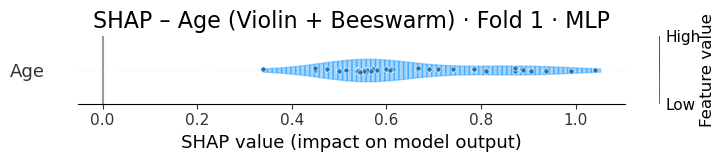

✅ Gráfico guardado: shap_latents_plus_sex_top10_violin.png/svg


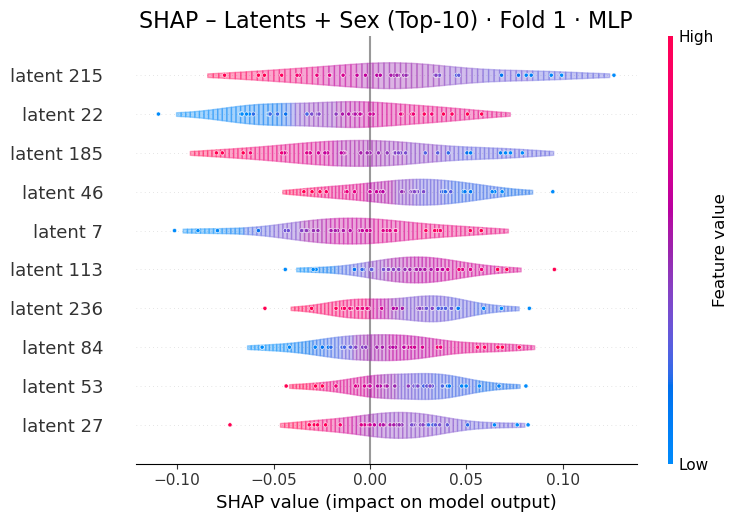

In [8]:
# === Importaciones y configuración inicial ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections
from tqdm.autonotebook import tqdm as notebook_tqdm
from pathlib import Path
import joblib, numpy as np, pandas as pd
import shap, re

# === Función de ayuda para ajustar la opacidad ===
def _ajustar_opacidad_violin(ax=None, alpha=0.35, subir_puntos=True):
    """
    Baja la opacidad de los violines creados por shap.summary_plot(plot_type='violin').
    alpha: 0 (transparente) ... 1 (opaco)
    subir_puntos: si hay puntos (beeswarm), los pone por encima con un borde.
    """
    ax = ax or plt.gca()
    # Ajusta la opacidad de los violines (PolyCollection)
    for pc in ax.findobj(mpl.collections.PolyCollection):
        pc.set_alpha(alpha)
    # Ajusta la opacidad de otros patches (por si acaso)
    for p in ax.patches:
        try: p.set_alpha(alpha)
        except Exception: pass
    if subir_puntos:
        # Pone los puntos del beeswarm (PathCollection) por delante
        for sc in ax.findobj(mpl.collections.PathCollection):
            sc.set_zorder(3)
            # Opcional: añade un borde blanco para que destaquen más
            sc.set_edgecolor("white")
            sc.set_linewidth(0.4)

# === Carga de datos ===
RUN_DIR = Path("./resultados_13_paper_qc_beta3")
FOLD    = 1
CLF     = "mlp"

pack = joblib.load(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_pack_{CLF}.joblib")
shap_vals = pack["shap_values"]            # (N,F) para clase positiva
Xtest     = pack["X_test"]                 # DataFrame post-preproc
featnames = list(map(str, pack["feature_names"]))

# Máscaras robustas para seleccionar features
latent_mask = np.array([re.search(r'(?:^|__)latent_\d+\b', c) is not None for c in featnames])
age_mask    = np.array([re.search(r'(?:^|__)Age\b', c) is not None for c in featnames])
# --- (AÑADIR esta línea junto a las máscaras) ---
sex_mask    = np.array([re.search(r'(?:^|__)Sex\b', c) is not None for c in featnames])


# === Gráfico combinado para 'Age' (Violin + Beeswarm) ===
if age_mask.any():
    plt.figure(figsize=(6, 2.8))
    # 1. Dibuja el violín
    shap.summary_plot(shap_vals[:, age_mask], Xtest.loc[:, age_mask],
                      plot_type="violin", show=False, max_display=1)

    # 2. 📌 Ajusta la opacidad del violín
    _ajustar_opacidad_violin(alpha=0.35)

    # 3. 📌 Añade los puntos (beeswarm) encima
    ax = plt.gca()
    vals = shap_vals[:, age_mask].ravel()
    # Un poco de jitter vertical para que los puntos no se superpongan
    y_jitter = 0.03 * np.random.randn(len(vals))
    ax.scatter(vals, y_jitter, s=14, zorder=3, c="#1f77b4",
               edgecolors="white", linewidths=0.4) # Usamos zorder=3 para ponerlos al frente

    plt.title(f"SHAP – Age (Violin + Beeswarm) · Fold {FOLD} · {CLF.upper()}")
    plt.tight_layout()
    # Guardamos con un nombre que refleje el nuevo contenido
    plt.savefig(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_age_combined.png", dpi=150)
    plt.savefig(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_age_combined.svg")
    print(f"✅ Gráfico guardado: shap_age_combined.png/svg")
    plt.show()
    plt.close()
else:
    print("⚠️ 'Age' no está entre las columnas de X_test (puede que el selector la haya removido).")

# === (REEMPLAZAR POR COMPLETO "Gráficos para features latentes" ===
# ===   por este bloque que hace Latentes + Sex ordenado por importancia) ===
TOPK = 10  # ajustá el K a gusto (p.ej., 15/20)

# Conjunto de features: todas las latentes + Sex (Age queda fuera a propósito)
mask_latent_or_sex = latent_mask | sex_mask

if mask_latent_or_sex.any():
    X_sel   = Xtest.loc[:, mask_latent_or_sex]
    S_sel   = shap_vals[:, mask_latent_or_sex]
    names   = np.array(featnames)[mask_latent_or_sex]

    # Ranking global por mean(|SHAP|)
    mean_abs = np.mean(np.abs(S_sel), axis=0)
    order    = np.argsort(mean_abs)[::-1]
    top_idx  = order[:TOPK]

    # Subconjunto Top-K
    S_top = S_sel[:, top_idx]
    X_top = X_sel.iloc[:, top_idx]
    names_top = names[top_idx]

    # Nombres bonitos (latent_i -> "latent i"; Sex -> "Sex")
    pretty = []
    for n in names_top:
        if re.search(r'(?:^|__)Sex\b', n):
            pretty.append("Sex")
        else:
            m = re.search(r'latent_(\d+)', n)
            pretty.append(f"latent {m.group(1)}" if m else n)

    # Plot tipo violin (ordenado por SHAP); si Sex no está en el Top-K, no aparece
    plt.figure(figsize=(8, 4 + 0.3*len(top_idx)))
    shap.summary_plot(
        S_top,
        X_top,
        feature_names=pretty,
        plot_type="violin",
        show=False,
        max_display=len(top_idx)
    )
    _ajustar_opacidad_violin(alpha=0.35)

    plt.title(f"SHAP – Latents + Sex (Top-{len(top_idx)}) · Fold {FOLD} · {CLF.upper()}")
    plt.tight_layout()
    plt.savefig(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_latents_plus_sex_top{len(top_idx)}_violin.png", dpi=150)
    plt.savefig(RUN_DIR / f"fold_{FOLD}/interpretability_shap/shap_latents_plus_sex_top{len(top_idx)}_violin.svg")
    print(f"✅ Gráfico guardado: shap_latents_plus_sex_top{len(top_idx)}_violin.png/svg")
    plt.show()
    plt.close()
else:
    print("⚠️ No se detectaron columnas latentes ni Sex en X_test.")


In [3]:
import re
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import shap

# ---------------------------------
# CONFIG GENERAL DE ESTILO PLOT
# ---------------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.size": 16,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

RUN_DIR = Path("./resultados_13_paper_qc_beta3")
CLF     = "mlp"

# Helper para bajar opacidad de los violines y subir los puntos
def _ajustar_opacidad_violin(ax=None, alpha=0.35):
    ax = ax or plt.gca()

    # violines = PolyCollection
    for pc in ax.findobj(mpl.collections.PolyCollection):
        pc.set_alpha(alpha)
        pc.set_edgecolor("black")
        pc.set_linewidth(0.8)

    # puntos tipo beeswarm = PathCollection
    for sc in ax.findobj(mpl.collections.PathCollection):
        sc.set_zorder(3)
        sc.set_edgecolor("white")
        sc.set_linewidth(0.4)

    # línea vertical en 0 (para interpretar dirección hacia AD)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)

    ax.grid(axis="x", linestyle=":", alpha=0.4)
    ax.set_xlabel("Valor SHAP (contribución → AD)")


def _prettify(name: str) -> str:
    """Nombre corto para las leyendas/tablas."""
    if name.lower() == "age":
        return "Age"
    if name.lower() == "sex":
        return "Sex"
    m = re.search(r'latent_(\d+)', name)
    if m:
        return f"latent {m.group(1)}"
    return name


def _violin_single_feature(shap_vals_feat, X_feat, feat_name_pretty, title_txt, out_png, out_svg):
    """
    Hace un plot tipo shap_latents_violin.png pero sólo para UNA feature (Age o Sex).
    Usamos shap.summary_plot(plot_type="violin") para esa columna.
    """
    plt.figure(figsize=(6, 2.5))
    shap.summary_plot(
        shap_vals_feat,
        X_feat,
        plot_type="violin",
        show=False,
        max_display=1
    )
    ax = plt.gca()
    ax.set_title(title_txt)
    ax.set_yticklabels([feat_name_pretty])
    _ajustar_opacidad_violin(ax=ax, alpha=0.35)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.savefig(out_svg, bbox_inches="tight")
    plt.close()


def _violin_topk_latents(S_lat, X_lat, lat_names_raw, top_k, title_txt, out_png, out_svg):
    """
    Mismo estilo que shap_latents_violin.png pero sólo con el TOP K latentes
    más importantes según mean(|SHAP|).
    """
    # importancia global por latente
    mean_abs_shap = np.mean(np.abs(S_lat), axis=0)  # shape (n_lat)
    order = np.argsort(mean_abs_shap)[::-1]
    top_idx = order[:top_k]

    S_top   = S_lat[:, top_idx]
    X_top   = X_lat.iloc[:, top_idx]
    names_t = [lat_names_raw[i] for i in top_idx]

    # violin
    plt.figure(figsize=(8, 4 + 0.3*top_k))
    shap.summary_plot(
        S_top,
        X_top,
        feature_names=[_prettify(n) for n in names_t],
        plot_type="violin",
        show=False,
        max_display=top_k
    )
    ax = plt.gca()
    ax.set_title(title_txt)
    _ajustar_opacidad_violin(ax=ax, alpha=0.35)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.savefig(out_svg, bbox_inches="tight")
    plt.close()

    return mean_abs_shap, order  # devolvemos para ranking


all_folds_rankings = []  # para luego hacer promedio entre folds

for FOLD in [1, 2, 3, 4, 5]:
    fold_dir      = RUN_DIR / f"fold_{FOLD}/interpretability_shap"
    pack_path     = fold_dir / f"shap_pack_{CLF}.joblib"
    pack          = joblib.load(pack_path)

    shap_vals     = pack["shap_values"]      # (N,F)
    Xtest         = pack["X_test"]           # DataFrame (N,F) post-procesado
    featnames     = list(map(str, pack["feature_names"]))

    # ------------------------
    # masks: latentes / Age / Sex
    # ------------------------
    latent_mask = np.array([re.search(r'latent_\d+\b', c) is not None for c in featnames])
    age_mask    = np.array([re.search(r'(?:^|__)Age\b', c) is not None for c in featnames])
    sex_mask    = np.array([re.search(r'(?:^|__)Sex\b', c) is not None for c in featnames])

    # =========================
    # 1) SEX -> shap_sex_violin
    # =========================
    if sex_mask.any():
        out_png = fold_dir / f"shap_sex_violin_fold{FOLD}.png"
        out_svg = fold_dir / f"shap_sex_violin_fold{FOLD}.svg"
        _violin_single_feature(
            shap_vals_feat = shap_vals[:, sex_mask],
            X_feat         = Xtest.loc[:, sex_mask],
            feat_name_pretty = "Sex",
            title_txt      = f"Sex · Fold {FOLD}",
            out_png        = out_png,
            out_svg        = out_svg,
        )

    # =========================
    # 2) AGE -> shap_age_violin
    # =========================
    if age_mask.any():
        out_png = fold_dir / f"shap_age_violin_fold{FOLD}.png"
        out_svg = fold_dir / f"shap_age_violin_fold{FOLD}.svg"
        _violin_single_feature(
            shap_vals_feat = shap_vals[:, age_mask],
            X_feat         = Xtest.loc[:, age_mask],
            feat_name_pretty = "Age",
            title_txt      = f"Age · Fold {FOLD}",
            out_png        = out_png,
            out_svg        = out_svg,
        )

    # =====================================================
    # 3) TOP-5 LATENTES -> shap_latents_top5_violin_foldX
    # =====================================================
    if latent_mask.any():
        S_lat          = shap_vals[:, latent_mask]
        X_lat          = Xtest.loc[:, latent_mask]
        lat_names_raw  = np.array(featnames)[latent_mask]

        out_png = fold_dir / f"shap_latents_top5_violin_fold{FOLD}.png"
        out_svg = fold_dir / f"shap_latents_top5_violin_fold{FOLD}.svg"

        mean_abs_shap_lat, order_full = _violin_topk_latents(
            S_lat        = S_lat,
            X_lat        = X_lat,
            lat_names_raw= lat_names_raw,
            top_k        = 5,
            title_txt    = f"Top-5 Latent features · Fold {FOLD}",
            out_png      = out_png,
            out_svg      = out_svg,
        )

    # =====================================================
    # 4) TABLA RANKING COMPLETO DE IMPORTANCIA GLOBAL
    #    (todas las features, no sólo latentes)
    #    -> mean(|SHAP|) por feature
    # =====================================================

    mean_abs_all = np.mean(np.abs(shap_vals), axis=0)  # (F,)
    df_rank = pd.DataFrame({
        "feature"        : featnames,
        "pretty_feature" : [_prettify(n) for n in featnames],
        "mean_abs_shap"  : mean_abs_all,
    }).sort_values("mean_abs_shap", ascending=False)

    # guardo ranking de este fold
    df_rank["fold"] = FOLD
    df_rank.to_csv(fold_dir / f"fold{FOLD}_shap_feature_importance_ranking.csv", index=False)

    all_folds_rankings.append(df_rank)

# =====================================================
# 5) PROMEDIO ENTRE FOLDS
#    Promediamos mean_abs_shap por feature a lo largo de los folds
#    y guardamos una tabla global.
# =====================================================

df_all = pd.concat(all_folds_rankings, ignore_index=True)

df_global = (
    df_all
    .groupby(["feature", "pretty_feature"], as_index=False)
    .agg(mean_abs_shap_across_folds=("mean_abs_shap", "mean"),
         std_abs_shap_across_folds =("mean_abs_shap", "std"),
         n_folds=("fold","nunique"))
    .sort_values("mean_abs_shap_across_folds", ascending=False)
)

df_global.to_csv(RUN_DIR / "shap_feature_importance_across_folds.csv", index=False)

print("✅ Hecho:")
print(" - shap_sex_violin_fold*.png/svg")
print(" - shap_age_violin_fold*.png/svg")
print(" - shap_latents_top5_violin_fold*.png/svg")
print(" - fold*_shap_feature_importance_ranking.csv")
print(" - shap_feature_importance_across_folds.csv (promedio en folds)")


✅ Hecho:
 - shap_sex_violin_fold*.png/svg
 - shap_age_violin_fold*.png/svg
 - shap_latents_top5_violin_fold*.png/svg
 - fold*_shap_feature_importance_ranking.csv
 - shap_feature_importance_across_folds.csv (promedio en folds)


In [4]:
import pandas as pd, pathlib as p

RUN_DIR = p.Path("./resultados_13_paper_qc_beta3")

for F in [1,2,3,4,5]:
    path = RUN_DIR / f"fold_{F}/interpretability_shap/fold{F}_shap_feature_importance_ranking.csv"
    print(f"\n=== Fold {F} · Top-15 (latentes + metadatos) ===")
    df = pd.read_csv(path).head(15)
    display(df[["pretty_feature","feature","mean_abs_shap"]])

print("\n=== Promedio entre folds · Top-20 ===")
display(pd.read_csv(RUN_DIR/"shap_feature_importance_across_folds.csv")
        .sort_values("mean_abs_shap_across_folds", ascending=False)
        .head(20))



=== Fold 1 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,Age,Age,0.652804
1,latent 215,latent_215,0.038105
2,latent 22,latent_22,0.034320
3,latent 185,latent_185,0.033600
4,latent 46,latent_46,0.030245
5,latent 7,latent_7,0.029499
6,latent 113,latent_113,0.029373
7,latent 236,latent_236,0.027651
8,latent 84,latent_84,0.026425
9,latent 53,latent_53,0.026299



=== Fold 2 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,Age,Age,0.268551
1,latent 49,latent_49,0.075000
2,latent 105,latent_105,0.064826
3,latent 200,latent_200,0.061816
4,latent 161,latent_161,0.057295
5,latent 7,latent_7,0.053103
6,latent 215,latent_215,0.053093
7,latent 45,latent_45,0.052368
8,latent 134,latent_134,0.051437
9,latent 18,latent_18,0.051337



=== Fold 3 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,Age,Age,0.447066
1,latent 216,latent_216,0.124587
2,latent 105,latent_105,0.120583
3,latent 213,latent_213,0.114730
4,latent 32,latent_32,0.111906
5,latent 5,latent_5,0.111123
6,latent 114,latent_114,0.107172
7,latent 193,latent_193,0.105669
8,latent 202,latent_202,0.105203
9,latent 182,latent_182,0.103834



=== Fold 4 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,Age,Age,1.082928
1,latent 1,latent_1,0.108997
2,latent 179,latent_179,0.100276
3,latent 7,latent_7,0.093471
4,latent 121,latent_121,0.090622
5,latent 200,latent_200,0.087141
6,latent 244,latent_244,0.076561
7,latent 113,latent_113,0.073373
8,latent 22,latent_22,0.067401
9,latent 232,latent_232,0.065875



=== Fold 5 · Top-15 (latentes + metadatos) ===


,pretty_feature,feature,mean_abs_shap
0,Age,Age,0.780231
1,latent 231,latent_231,0.019492
2,latent 246,latent_246,0.018527
3,latent 237,latent_237,0.014304
4,latent 52,latent_52,0.013168
5,latent 200,latent_200,0.013163
6,latent 81,latent_81,0.013035
7,latent 160,latent_160,0.012517
8,latent 143,latent_143,0.012287
9,latent 202,latent_202,0.011968



=== Promedio entre folds · Top-20 ===


,feature,pretty_feature,mean_abs_shap_across_folds,std_abs_shap_across_folds,n_folds
0,Age,Age,0.646316,0.312655,5
1,latent_7,latent 7,0.051132,0.035361,5
2,latent_105,latent 105,0.049122,0.047419,5
3,latent_200,latent 200,0.047472,0.032345,5
4,latent_215,latent 215,0.045606,0.026767,5
5,latent_1,latent 1,0.044566,0.040309,5
6,latent_213,latent 213,0.044010,0.043828,5
7,latent_237,latent 237,0.043030,0.033235,5
8,latent_161,latent 161,0.042473,0.031767,5
9,latent_22,latent 22,0.042005,0.025636,5


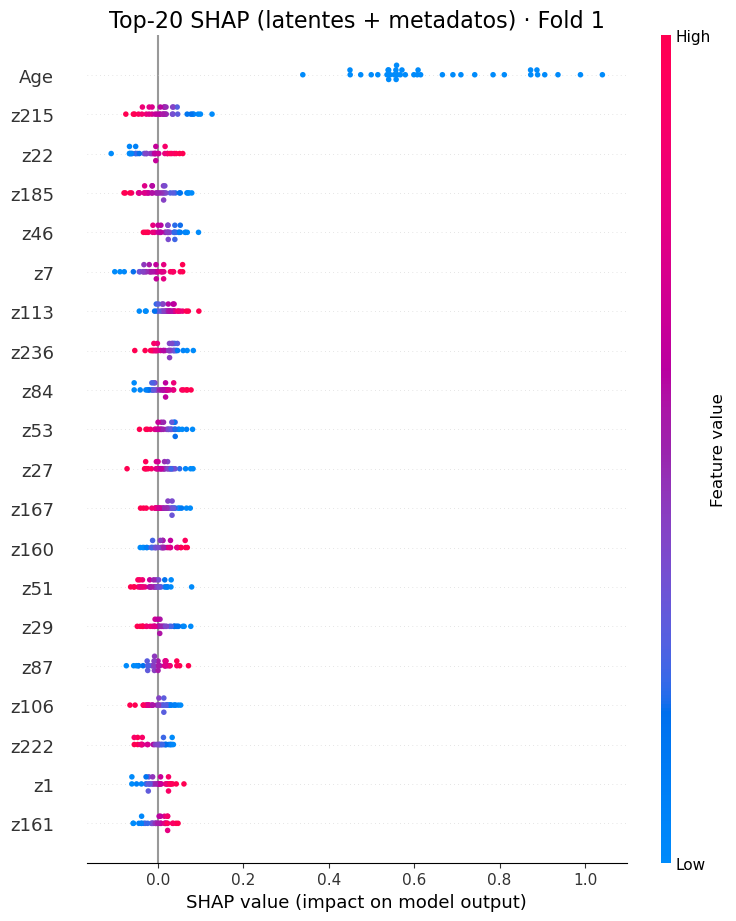

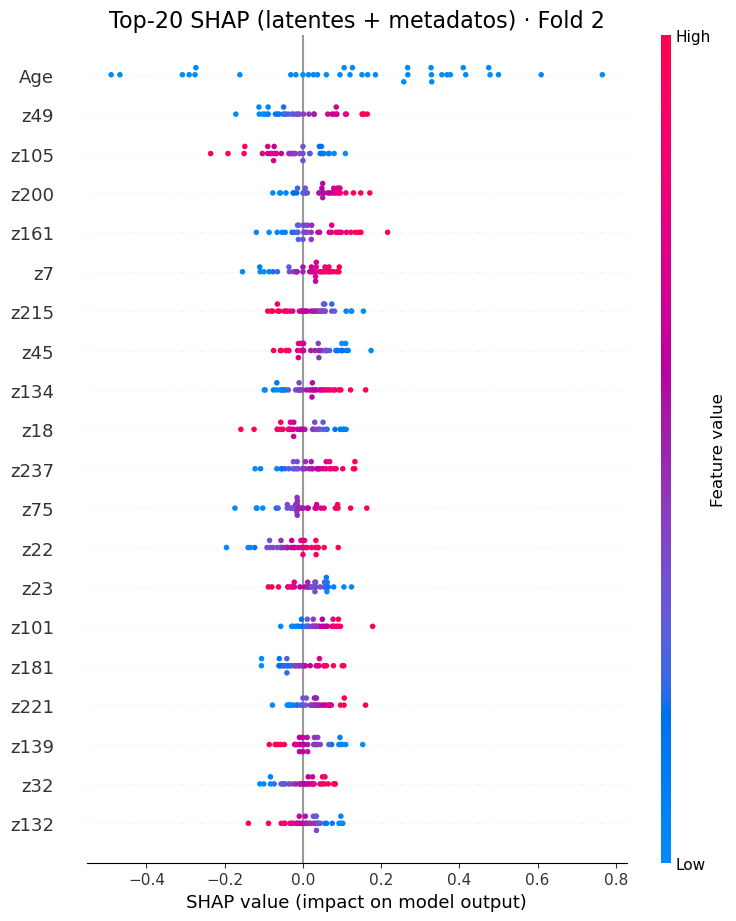

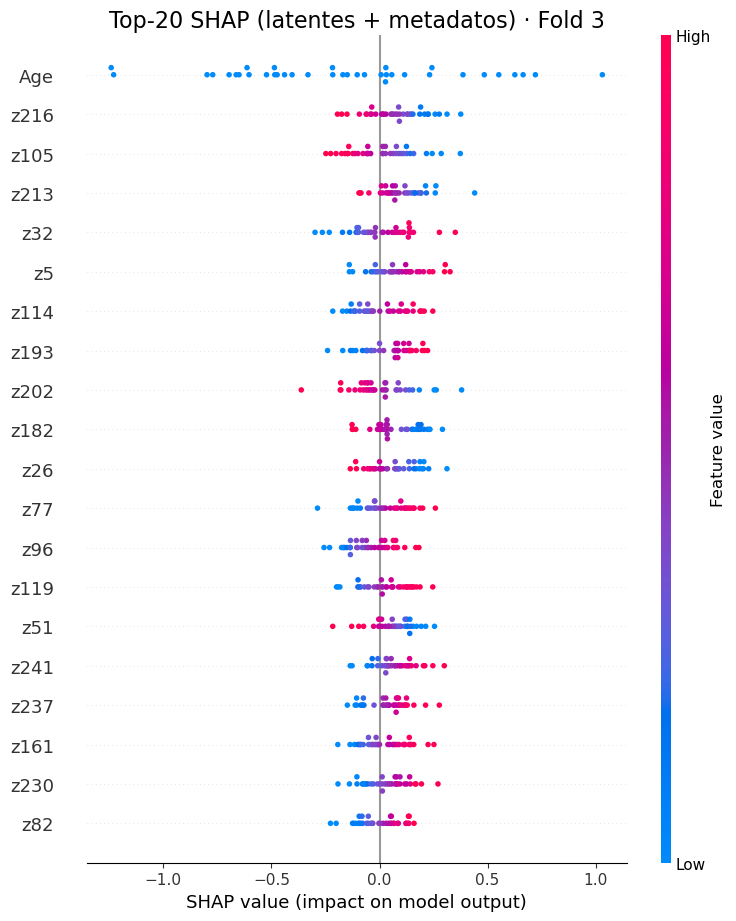

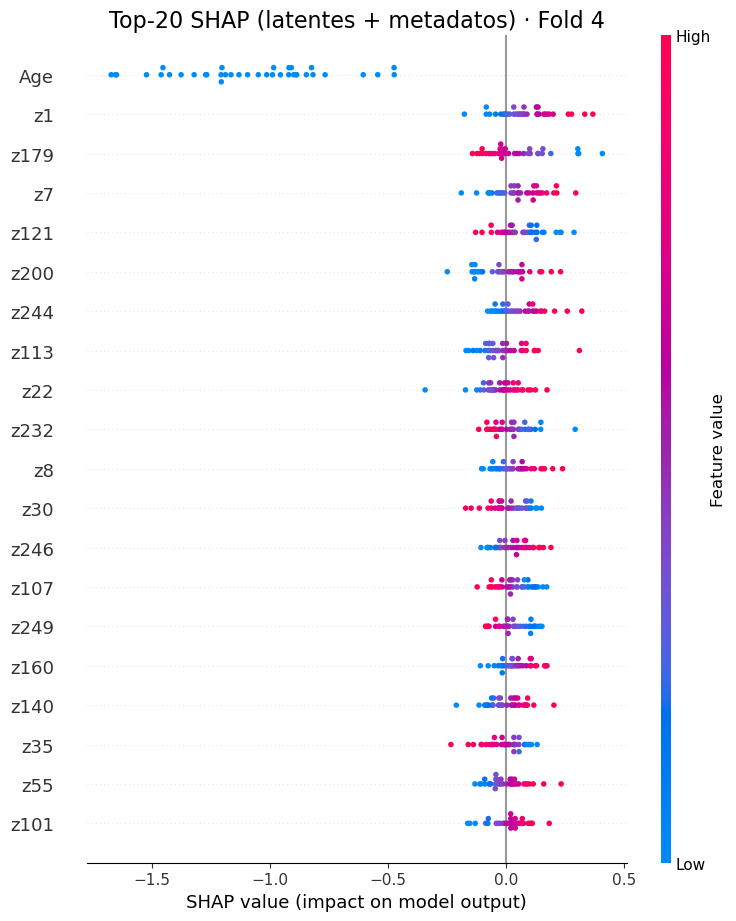

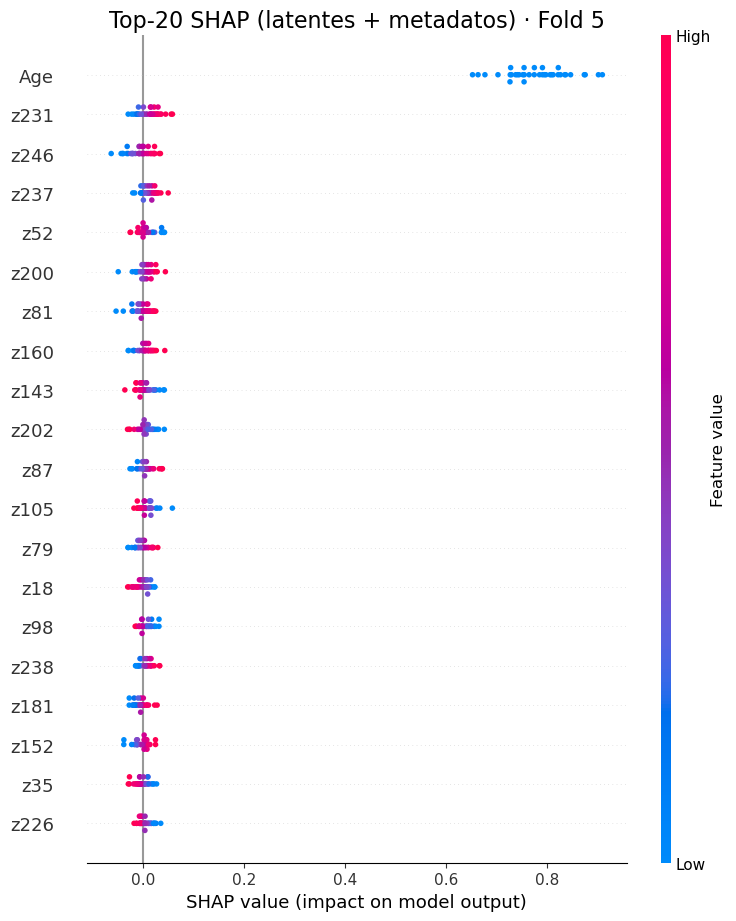

In [5]:
import re, joblib, numpy as np, pandas as pd
from pathlib import Path
import shap, matplotlib.pyplot as plt

RUN_DIR = Path("./resultados_13_paper_qc_beta3")
CLF = "mlp"
TOPK = 20  # cambiá este K si querés

for FOLD in [1,2,3,4,5]:
    fold_dir  = RUN_DIR / f"fold_{FOLD}/interpretability_shap"
    pack = joblib.load(fold_dir / f"shap_pack_{CLF}.joblib")
    S = pack["shap_values"]        # (N,F)
    X = pack["X_test"]             # DataFrame (N,F)
    names = list(map(str, pack["feature_names"]))

    # ranking global (todas las features)
    mean_abs = np.abs(S).mean(axis=0)
    df_rank = (pd.DataFrame({"feature": names,
                             "mean_abs_shap": mean_abs})
               .assign(pretty_feature=lambda d: d["feature"].map(
                   lambda n: "Age" if n.lower().endswith("age")
                   else "Sex" if n.lower().endswith("sex")
                   else re.sub(r".*latent_(\d+).*", r"z\1", n)))
               .sort_values("mean_abs_shap", ascending=False))
    df_rank["fold"] = FOLD
    df_rank.to_csv(fold_dir / f"fold{FOLD}_shap_feature_importance_ranking.csv", index=False)

    # beeswarm de top-K (latentes + metadatos)
    top_idx = df_rank.index[:TOPK]
    cols = [df_rank.loc[i,"feature"] for i in top_idx]
    X_top = X.loc[:, cols]
    S_top = S[:, [names.index(c) for c in cols]]
    plt.figure(figsize=(8,6))
    shap.summary_plot(S_top, X_top, show=False, max_display=TOPK, feature_names=list(df_rank.loc[top_idx,"pretty_feature"]))
    plt.title(f"Top-{TOPK} SHAP (latentes + metadatos) · Fold {FOLD}")
    plt.tight_layout()
    plt.savefig(fold_dir / f"fold{FOLD}_shap_top{TOPK}_mixed_beeswarm.png", dpi=300)
    plt.show()
    plt.close()


In [6]:
# 1) ¿Age realmente es constante en X_test del pack?
X = pack["X_test"]
age_cols = [c for c in X.columns if c.endswith("Age") or c.endswith("__Age")]
print("std(Age) en X_test:", X[age_cols].std().to_string())

# 2) ¿Age es constante en el background procesado?
import joblib, numpy as np
fold_dir = Path(RUN_DIR)/f"fold_{FOLD}"
bg = joblib.load(fold_dir/"shap_background_proc_mlp_global_cn.joblib")
age_cols_bg = [c for c in bg.columns if c.endswith("Age") or c.endswith("__Age")]
print("std(Age) en BG:", bg[age_cols_bg].std().to_string())

# 3) Magnitud SHAP de Age (debería ser << a la de latentes top si Age quedó fijo)
S = pack["shap_values"]
feat = list(map(str, pack["feature_names"]))
i_age = [i for i,n in enumerate(feat) if n.endswith("Age") or n.endswith("__Age")]
print("mean(|SHAP|) Age:", np.abs(S[:, i_age]).mean())


std(Age) en X_test: Age    2.199163e-19
std(Age) en BG: Age    1.429137e-14
mean(|SHAP|) Age: 0.78023136
